# Confinement Time Scaling Analysis

이 노트북은 토카막 confinement time scaling 분석을 위한 전체 워크플로우를 제공합니다.

## 노트북 구조

1. **Part 1: Single Shot Workflow Test** - 하나의 샷을 사용하여 전체 워크플로우를 테스트합니다
   - 샷 선택 및 ODS 로드
   - 파라미터 추출 및 확인
   - 시각화 및 분석

2. **Part 2: Full Dataset Statistical Analysis** - 전체 샷에 대한 통계적 분석을 수행합니다
   - 모든 core_profile 샷에서 파라미터 추출
   - OLS 회귀 분석을 통한 scaling law 지수 도출
   - 결과 시각화 및 물리적 검증

3. **Part 3: Comparison with TS shot and aribitrary shot**

## 초기 설정 및 샷 목록 확인

In [1]:
import vaft
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import omas
from omfit_classes.omfit_eqdsk import OMFITgeqdsk

print("Loading available Thomson Scattering shots...")
df = vaft.database.exist_ts_file()
core_profile_shots = df[df['Status'] == 'core_profile']
shot_numbers = core_profile_shots['Shot Number'].values

print(f"\nFound {len(shot_numbers)} shots with core_profile status:")
print(shot_numbers)

Loading available Thomson Scattering shots...
Available Thomson Scattering Shots:

|   Index |   Shot Number | Last Processed             | Status       |
|---------|---------------|----------------------------|--------------|
|       1 |         22027 | 2023-02-02T23:24:20        | invalid      |
|       2 |         39513 | 2024-08-06T11:18:45.556514 | thomson_only |
|       3 |         39515 | 2024-08-06T11:19:39.748631 | thomson_only |
|       4 |         39906 | 2024-08-06T11:20:05.668157 | core_profile |
|       5 |         39915 | 2024-05-14T16:42:35.439538 | invalid      |
|       6 |         39916 | 2024-07-08T20:11:09.953256 | invalid      |
|       7 |         39917 | 2023-07-05T20:47:14        | thomson_only |
|       8 |         40282 | 2024-08-06T11:20:28.826835 | core_profile |
|       9 |         40323 | 2023-07-28T16:04:09        | core_profile |
|      10 |         40324 | 2023-07-28T16:05:00        | invalid      |
|      11 |         40325 | 2023-07-28T16:06:39      

In [2]:
test_shot = shot_numbers[1]  # Use first available shot
print(f"\nSelected test shot: {test_shot}")


Selected test shot: 40282


---

# Part 1: Single Shot Workflow Test

하나의 샷을 사용하여 전체 워크플로우를 테스트합니다. 이 섹션에서는:
1. ODS 로드 및 데이터 확인
2. 파라미터 추출 (gen_core_profiles_history 함수 사용)
3. 통계 분석 및 시각화

### 1.1 ODS 로드 및 데이터 확인

In [3]:
ods=vaft.database.load(test_shot,'public')

Successfully loaded ODS data for shot: 40282


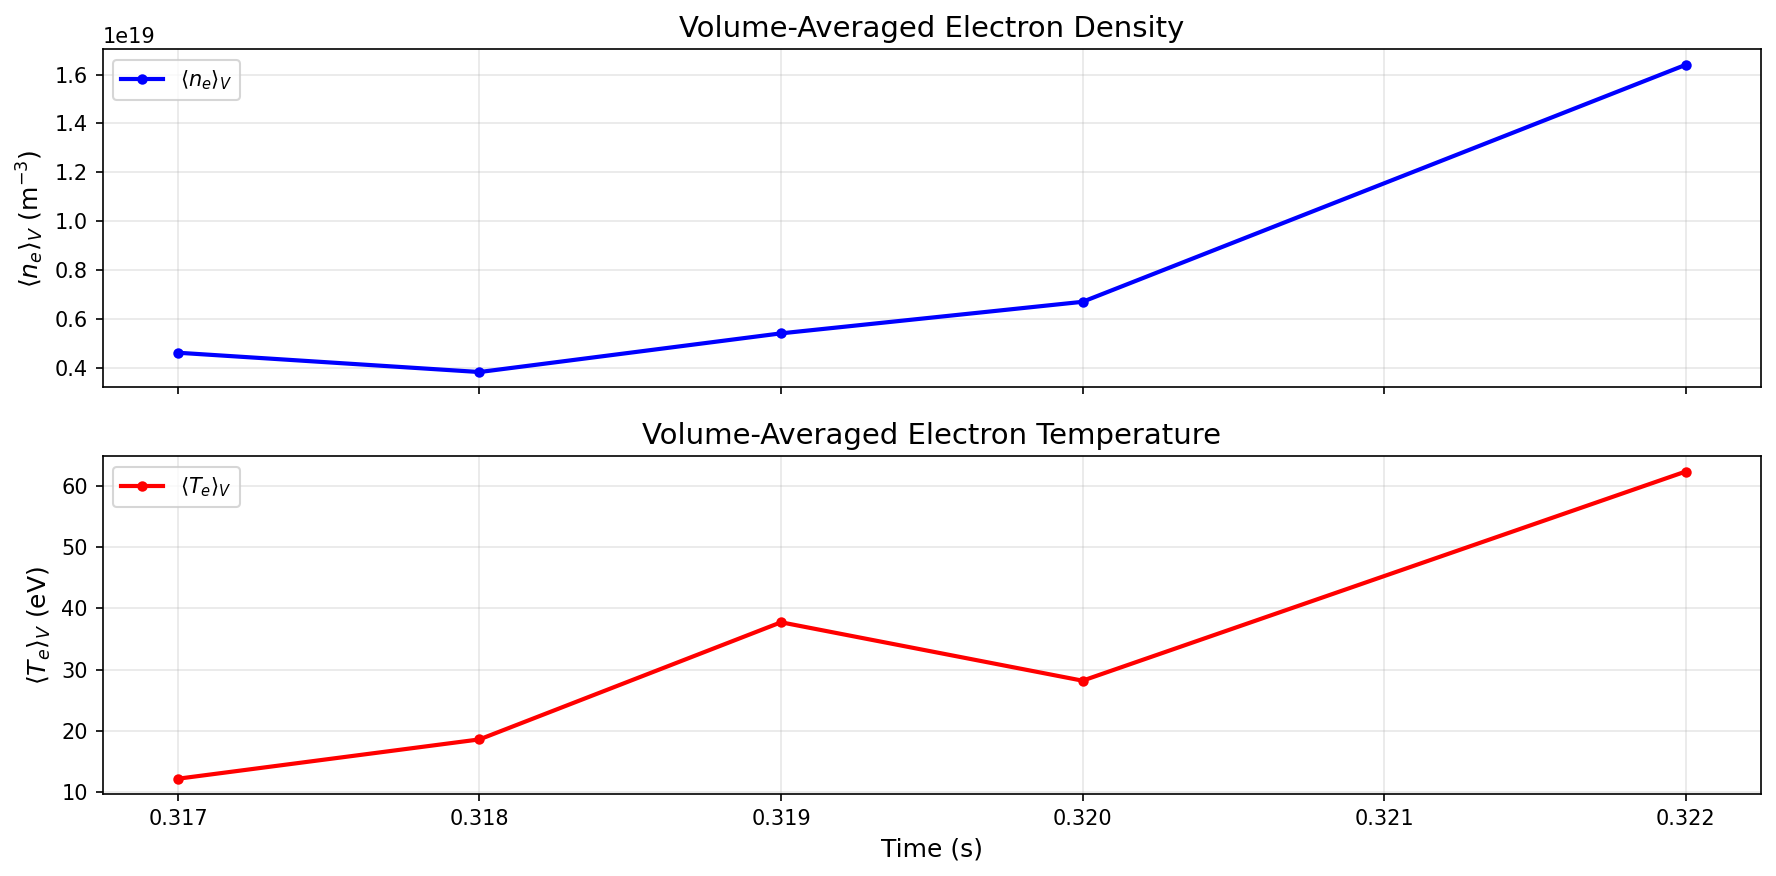

In [4]:
vaft.plot.plot_electron_time_volume_averaged(ods)


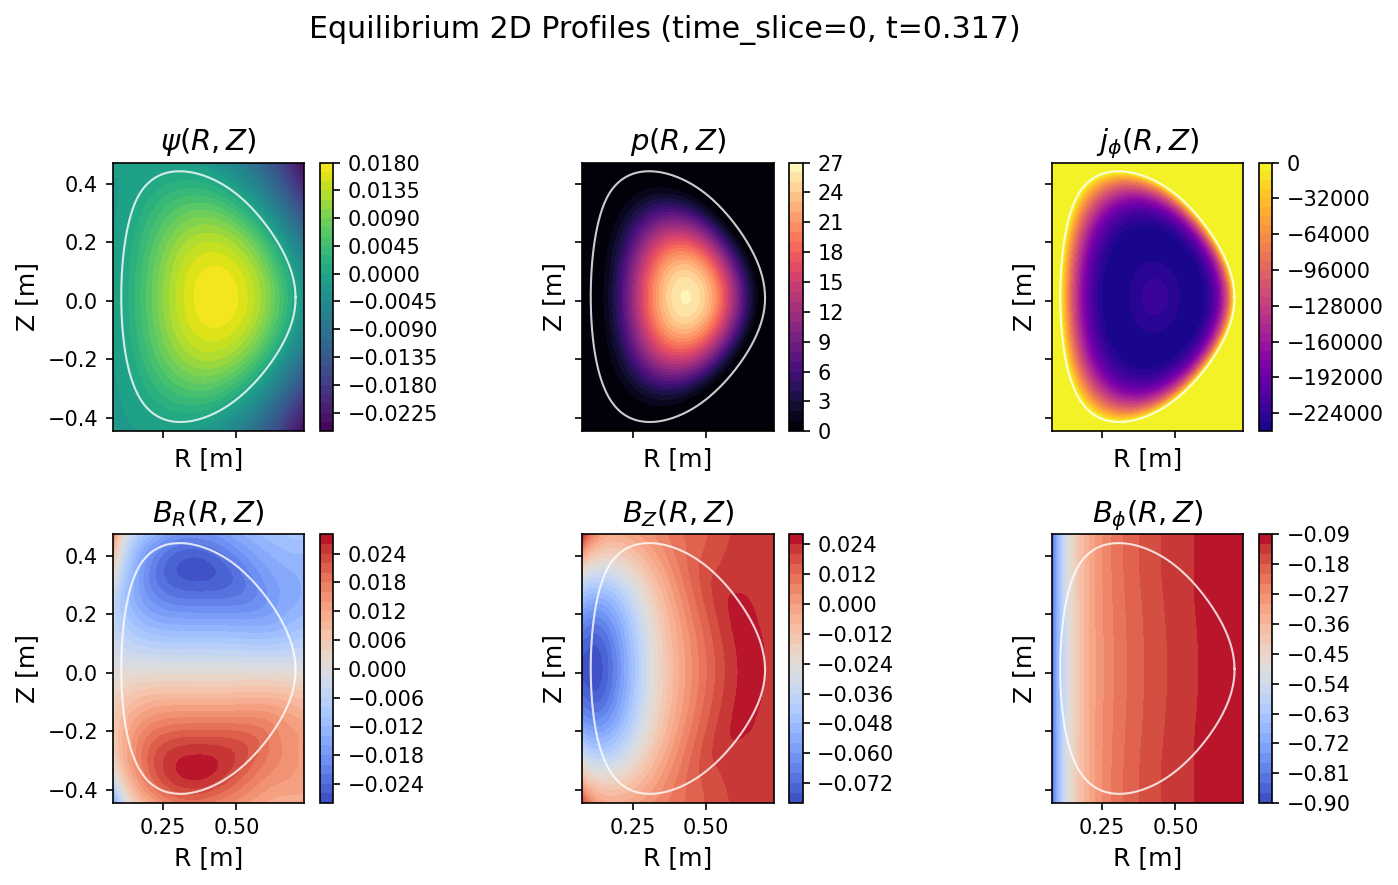

In [5]:
vaft.plot.equilibrium_2d_profiles(ods)
plt.show()

In [6]:
# Verify data availability
has_equilibrium = 'equilibrium.time_slice' in ods and len(ods['equilibrium.time_slice']) > 0
has_core_profiles = 'core_profiles.profiles_1d' in ods and len(ods['core_profiles.profiles_1d']) > 0

print(f"Equilibrium available: {has_equilibrium}")
print(f"Core profiles available: {has_core_profiles}")

if has_equilibrium:
    n_eq = len(ods['equilibrium.time_slice'])
    eq_time = ods['equilibrium.time_slice'][0].get('time', 0)
    print(f"Number of equilibrium time slices: {n_eq}")
    print(f"First equilibrium time: {eq_time:.4f} s")

if has_core_profiles:
    n_cp = len(ods['core_profiles.profiles_1d'])
    cp_time = ods['core_profiles.profiles_1d'][0].get('time', 0)
    print(f"Number of core profile time slices: {n_cp}")
    print(f"First core profile time: {cp_time:.4f} s")

Equilibrium available: True
Core profiles available: True
Number of equilibrium time slices: 5
First equilibrium time: 0.3170 s
Number of core profile time slices: 5
First core profile time: 0.3170 s


### 1.2 Extract and plot confinement-time related paratmer from a specific ods

In [7]:
n_slices = len(ods['core_profiles.profiles_1d'])

P_B_pressure_list = []
P_B_electron_list = []
# Process each time slice
for time_slice in range(n_slices):
    P_B_pressure, P_B_electron = vaft.omas.compute_bremsstrahlung_power(
        ods, time_slice=time_slice, Z_eff=2
    )
    P_B_pressure_list.append(P_B_pressure)
    P_B_electron_list.append(P_B_electron)
        # shot_labels.append(shot_label)
        # time_slices.append(time_slice)

print(P_B_pressure_list)
print(P_B_electron_list)


[3.141033970447789, 2.118058686256844, 3.2332478373329345, 2.7179407958797173, 7.3460389724402715]
[3.1501387919542725, 2.124305236665434, 3.2426458042582693, 2.7258090254519365, 7.367260738123863]


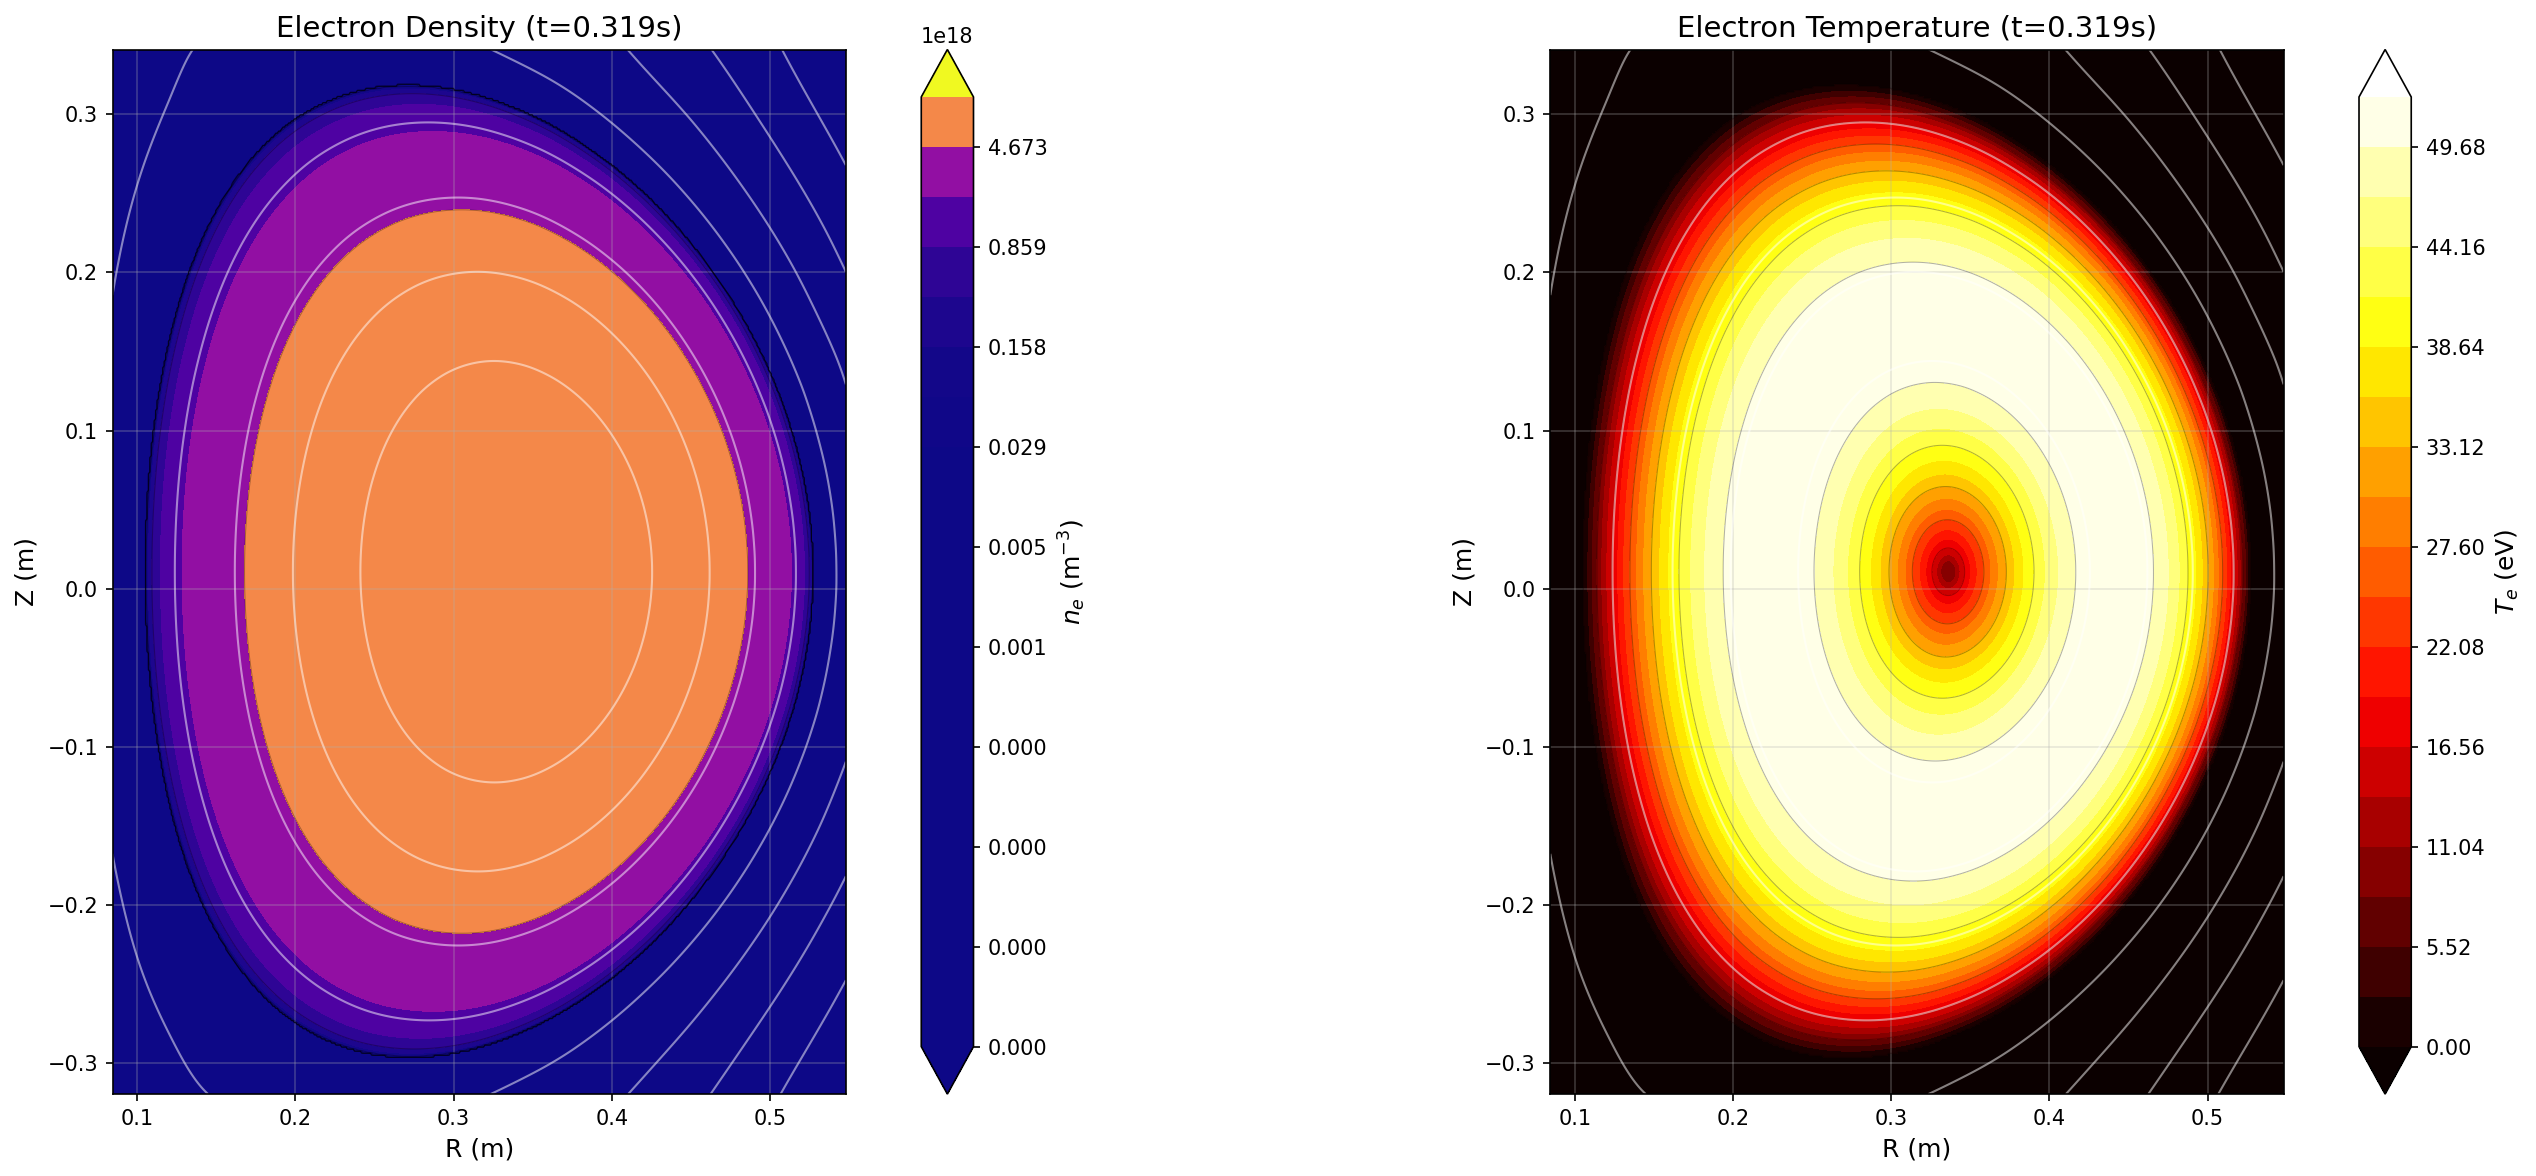

In [8]:
vaft.plot.plot_electron_2d_profile(ods, time_slice=2)

In [9]:
vaft.omas.compute_volume_averaged_pressure(ods)

array([9.22999812, 7.41013276, 5.59884288, 4.33853508, 2.588398  ])

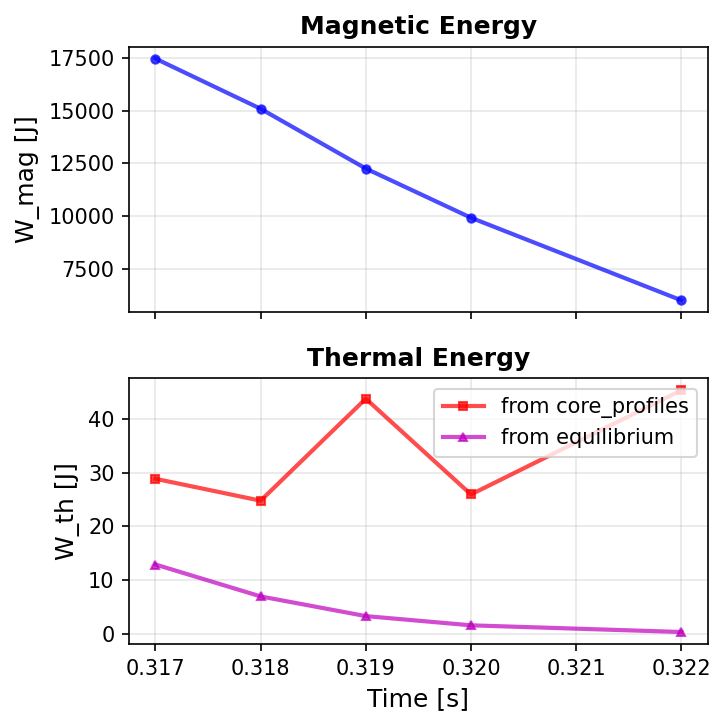

In [10]:
vaft.plot.time_energy(ods)
plt.show()

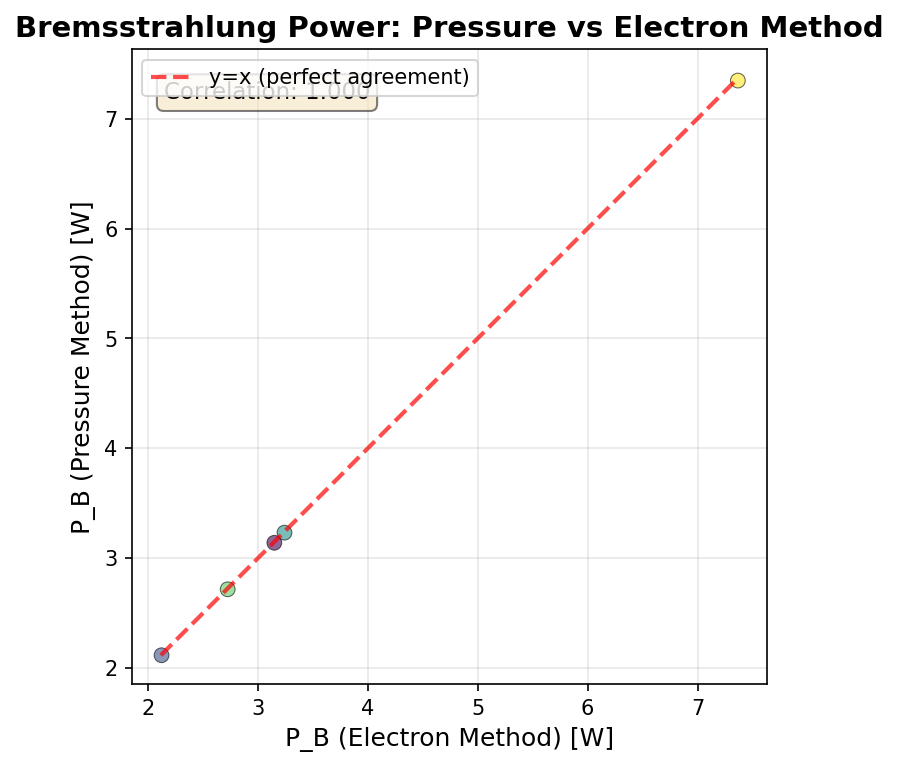

In [11]:
vaft.plot.plot_bremsstrahlung_power_scaling_vs_fundamental_method(ods)
plt.show()

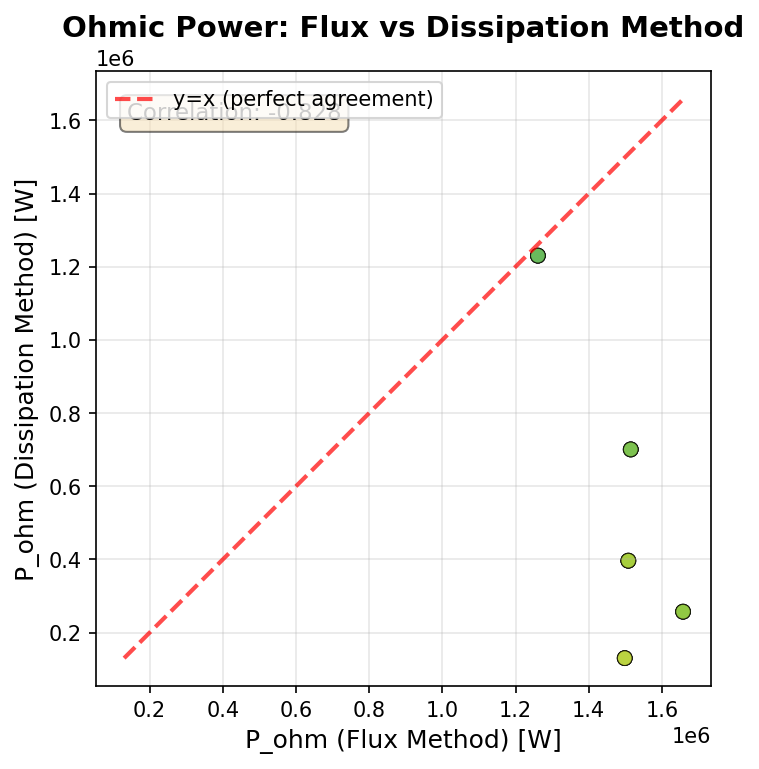

In [12]:
vaft.plot.plot_ohmic_power_flux_vs_dissipation_method(ods)
plt.show()

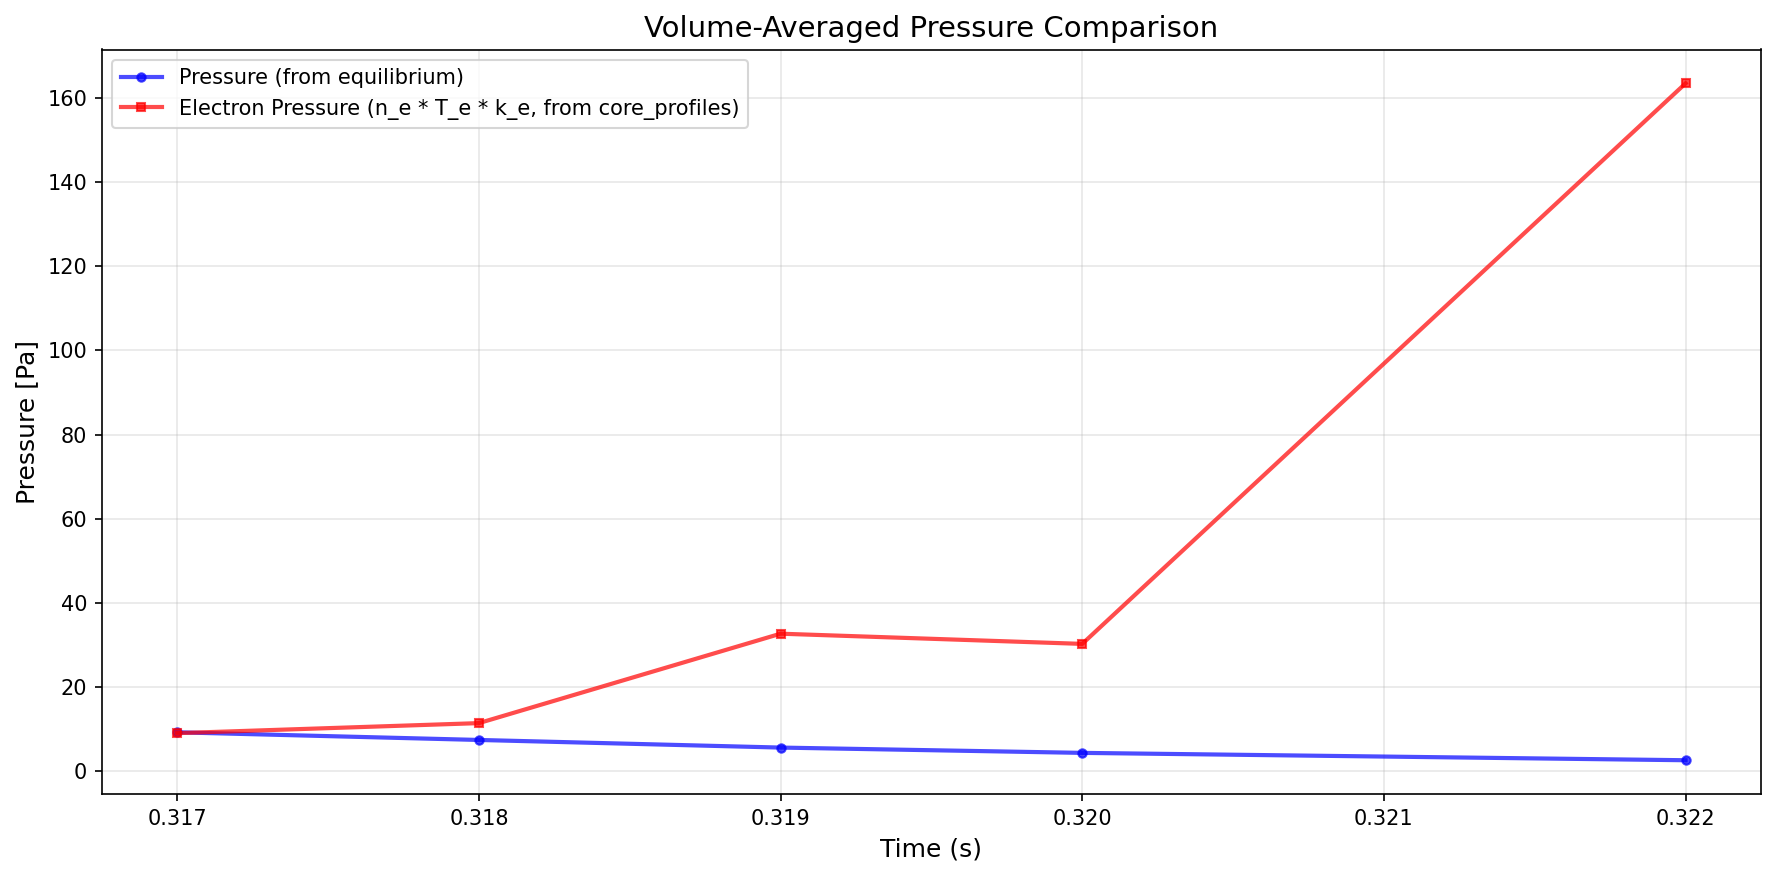

In [13]:
vaft.plot.plot_equilibrium_and_core_profiles_pressure(ods)


Power Balance Results:
{'time': array([0.317, 0.318, 0.319, 0.32 , 0.322]), 'V_loop': array([16.34509381, 16.96593946, 15.9534624 , 13.48821717, 11.82437211]), 'V_ind': array([34.86598109, 40.63683412, 44.73320789, 42.81468474, 50.7849706 ]), 'V_res': array([-18.52088728, -23.67089466, -28.77974549, -29.32646757,
       -38.96059849]), 'P_ohm_flux': array([1261061.47841731, 1514820.94358229, 1657737.94652501,
       1508175.64142229, 1498356.78970162]), 'P_ohm_diss': array([1230160.63393539,  700642.93660612,  257157.63788437,
        396542.87307174,  130246.27802757]), 'P_aux': array([0., 0., 0., 0., 0.]), 'P_heat': array([1230160.63393539,  700642.93660612,  257157.63788437,
        396542.87307174,  130246.27802757]), 'P_rad': array([0., 0., 0., 0., 0.]), 'dWdt': array([-1811.38047568,  3315.23039053,   258.09609214, -3846.63555938,
        4311.39146678]), 'P_loss': array([1231972.01441108,  697327.70621559,  256899.54179222,
        400389.50863112,  125934.88656079])}


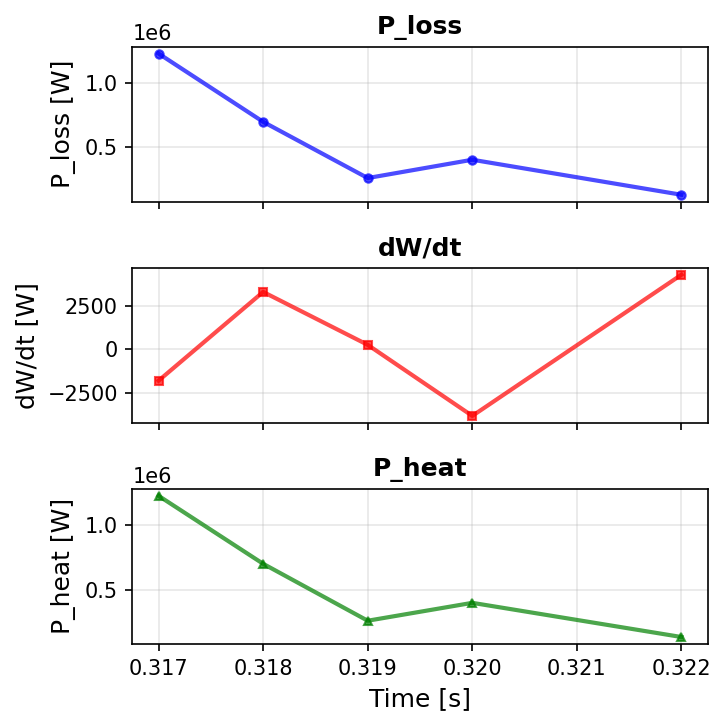

In [14]:
# Step 2: Calculate power balance
import vaft

# Calculate power balance for all time slices
power_balance = vaft.omas.compute_power_balance(ods)

# Display power balance results
print("\nPower Balance Results:")
print(power_balance)

vaft.plot.time_power_balance(ods)
plt.show()

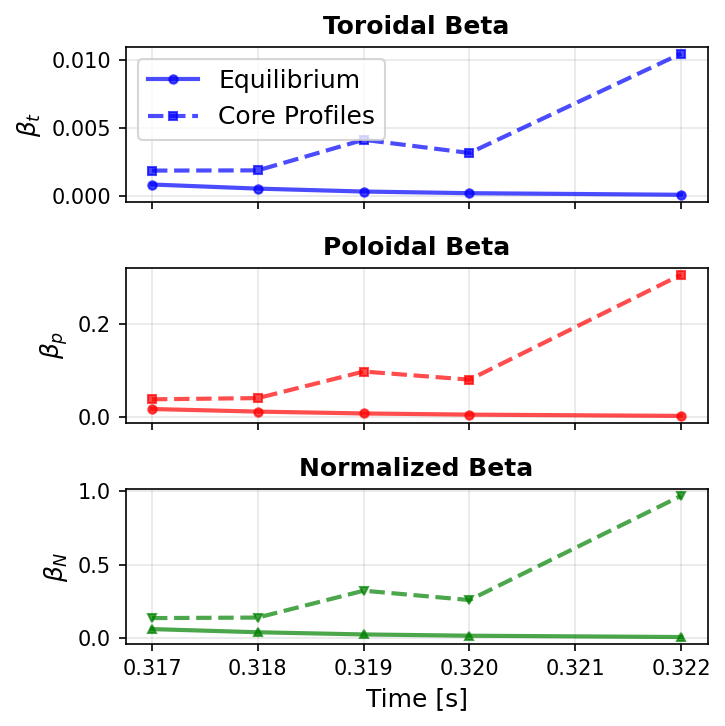

In [15]:
vaft.plot.time_beta(ods)
plt.show()

In [16]:
# Calculate confinement time parameters
from vaft.omas import compute_confiment_time_paramters
from vaft.omas import update_core_profiles_global_quantities_volume_average

# Update volume-averaged quantities if needed
update_core_profiles_global_quantities_volume_average(ods)
print("Volume-averaged quantities updated.")

# Calculate confinement time parameters for each time slice
Z_eff = 2.0  # Effective charge
M = 1.0      # Average ion mass [amu]

n_eq = len(ods['equilibrium']['time_slice'])
tau_IPB89_list = []
tau_H98y2_list = []
tau_NSTX_list = []
H_factor_list = []
tau_exp_list = []
time_list = []

print(f"\nCalculating confinement time parameters for {n_eq} time slices...")

for time_slice in range(n_eq):
    tau_IPB89, tau_H98y2, tau_NSTX, H_factor, tau_exp = compute_confiment_time_paramters(
        ods, time_slice=time_slice, Z_eff=Z_eff, M=M
    )
        
    eq_ts = ods['equilibrium']['time_slice'][time_slice]
    time_val = eq_ts.get('time', time_slice)
    
    tau_IPB89_list.append(tau_IPB89)
    tau_H98y2_list.append(tau_H98y2)
    tau_NSTX_list.append(tau_NSTX)
    H_factor_list.append(H_factor)
    tau_exp_list.append(tau_exp)
    time_list.append(time_val)
        
    print(f"  Time slice {time_slice} (t={time_val:.4f}s): τ_E,exp={tau_exp*1e3:.3f} ms, τ_E,H98y2={tau_H98y2*1e3:.3f} ms, H={H_factor:.3f}")
        

tau_IPB89_arr = np.array(tau_IPB89_list)
tau_H98y2_arr = np.array(tau_H98y2_list)
tau_NSTX_arr = np.array(tau_NSTX_list)
H_factor_arr = np.array(H_factor_list)
tau_exp_arr = np.array(tau_exp_list)
time_arr = np.array(time_list)

print(f"\nSummary:")
print(f"  Average τ_E,exp: {np.mean(tau_exp_arr)*1e3:.3f} ms")
print(f"  Average τ_E,H98y2: {np.mean(tau_H98y2_arr)*1e3:.3f} ms")
print(f"  Average H-factor: {np.mean(H_factor_arr):.3f}")

Volume-averaged quantities updated.

Calculating confinement time parameters for 5 time slices...
  Time slice 0 (t=0.3170s): τ_E,exp=0.023 ms, τ_E,H98y2=0.417 ms, H=0.037
  Time slice 1 (t=0.3180s): τ_E,exp=0.035 ms, τ_E,H98y2=0.421 ms, H=0.054
  Time slice 2 (t=0.3190s): τ_E,exp=0.170 ms, τ_E,H98y2=0.659 ms, H=0.205
  Time slice 3 (t=0.3200s): τ_E,exp=0.065 ms, τ_E,H98y2=0.357 ms, H=0.129
  Time slice 4 (t=0.3220s): τ_E,exp=0.360 ms, τ_E,H98y2=0.466 ms, H=0.738

Summary:
  Average τ_E,exp: 0.131 ms
  Average τ_E,H98y2: 0.464 ms
  Average H-factor: 0.233



=== Step 6: Confinement Time Comparison ===


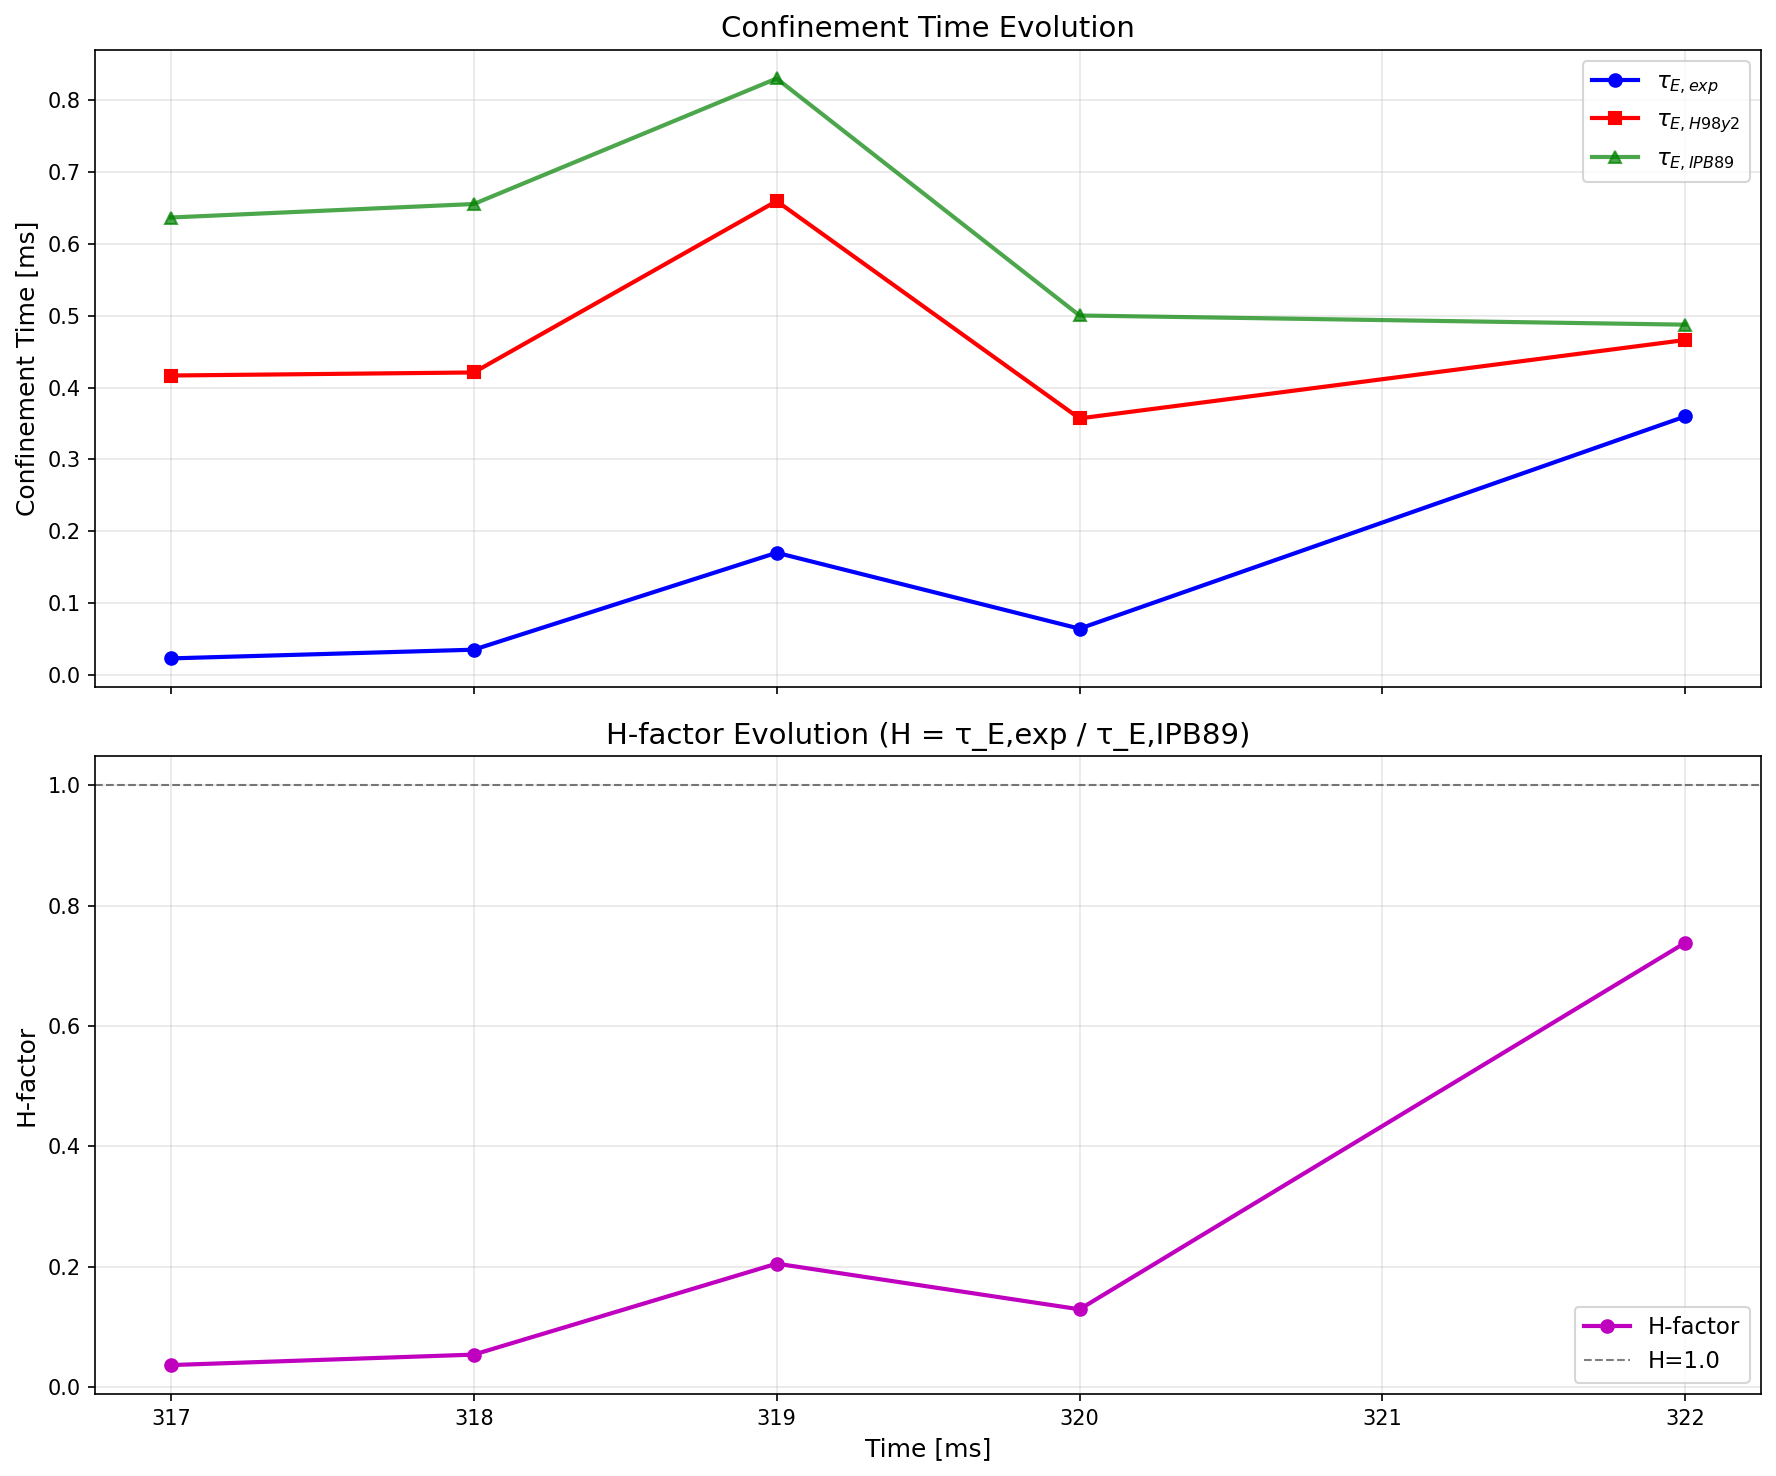

In [17]:
# Final comparison plot - τ_E,exp vs τ_E,H98y2
print("\n=== Step 6: Confinement Time Comparison ===")

fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Time evolution of confinement times
axs[0].plot(time_arr * 1e3, tau_exp_arr * 1e3, 'b-o', label=r'$\tau_{E,exp}$', linewidth=2, markersize=6)
axs[0].plot(time_arr * 1e3, tau_H98y2_arr * 1e3, 'r-s', label=r'$\tau_{E,H98y2}$', linewidth=2, markersize=6)
axs[0].plot(time_arr * 1e3, tau_IPB89_arr * 1e3, 'g-^', label=r'$\tau_{E,IPB89}$', linewidth=2, markersize=6, alpha=0.7)
axs[0].set_ylabel('Confinement Time [ms]', fontsize=12)
axs[0].set_title('Confinement Time Evolution', fontsize=14)
axs[0].legend(fontsize=11, loc='best')
axs[0].grid(True, alpha=0.3)

# Plot 2: H-factor evolution
axs[1].plot(time_arr * 1e3, H_factor_arr, 'm-o', label='H-factor', linewidth=2, markersize=6)
axs[1].axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='H=1.0')
axs[1].set_xlabel('Time [ms]', fontsize=12)
axs[1].set_ylabel('H-factor', fontsize=12)
axs[1].set_title('H-factor Evolution (H = τ_E,exp / τ_E,IPB89)', fontsize=14)
axs[1].legend(fontsize=11, loc='best')
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Statistical Analysis of Confinement Time Scaling

이 섹션은 전체 데이터셋에 대한 통계적 분석을 수행합니다:
1. 엑셀 파일에서 파라미터 데이터 로드
2. 로그 변환 및 OLS 회귀 분석
3. 결과 시각화 및 해석

In [18]:
# Step 1: Generate core profiles history Excel file (if not exists)
# This step extracts parameters from ODS files and saves to Excel

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'workflow', 'automatic_pipeline_3_data_summary'))
import gen_core_profiles_history
from vaft.process import statistical_analysis

excel_file = "core_profiles_history.xlsx"

if not os.path.exists(excel_file):
    print("Generating core profiles history Excel file...")
    print("This may take a while as it processes all core_profile shots...")
    df_history = gen_core_profiles_history.generate_core_profiles_history_excel(max_shots=None)
    print(f"\nExcel file generated: {excel_file}")
else:
    print(f"Excel file already exists: {excel_file}")
    print("Skipping generation step.")

Generating core profiles history Excel file...
This may take a while as it processes all core_profile shots...
Available Thomson Scattering Shots:

|   Index |   Shot Number | Last Processed             | Status       |
|---------|---------------|----------------------------|--------------|
|       1 |         22027 | 2023-02-02T23:24:20        | invalid      |
|       2 |         39513 | 2024-08-06T11:18:45.556514 | thomson_only |
|       3 |         39515 | 2024-08-06T11:19:39.748631 | thomson_only |
|       4 |         39906 | 2024-08-06T11:20:05.668157 | core_profile |
|       5 |         39915 | 2024-05-14T16:42:35.439538 | invalid      |
|       6 |         39916 | 2024-07-08T20:11:09.953256 | invalid      |
|       7 |         39917 | 2023-07-05T20:47:14        | thomson_only |
|       8 |         40282 | 2024-08-06T11:20:28.826835 | core_profile |
|       9 |         40323 | 2023-07-28T16:04:09        | core_profile |
|      10 |         40324 | 2023-07-28T16:05:00        | inv

Processing shots:   0%|          | 0/29 [00:00<?, ?it/s]WARNING:vaft.omas.process_wrapper:Time slice 0: No matching core profile time slice found, skipping


Successfully loaded ODS data for shot: 39906


Processing shots:   3%|▎         | 1/29 [00:08<04:02,  8.65s/it]

Successfully loaded ODS data for shot: 40282


Processing shots:  10%|█         | 3/29 [00:26<03:47,  8.74s/it]

Successfully loaded ODS data for shot: 40323


Processing shots:  14%|█▍        | 4/29 [00:34<03:27,  8.29s/it]

Successfully loaded ODS data for shot: 40325


Processing shots:  17%|█▋        | 5/29 [00:41<03:13,  8.06s/it]

Successfully loaded ODS data for shot: 40326


Processing shots:  21%|██        | 6/29 [00:49<03:03,  8.00s/it]

Successfully loaded ODS data for shot: 40327


Processing shots:  24%|██▍       | 7/29 [00:57<02:55,  7.97s/it]

Successfully loaded ODS data for shot: 40328
Successfully loaded ODS data for shot: 40330


Processing shots:  31%|███       | 9/29 [01:15<02:44,  8.23s/it]

Successfully loaded ODS data for shot: 40331


Processing shots:  34%|███▍      | 10/29 [01:22<02:31,  8.00s/it]

Successfully loaded ODS data for shot: 41261


Successfully loaded ODS data for shot: 41262


Processing shots:  38%|███▊      | 11/29 [01:31<02:28,  8.26s/it]

Successfully loaded ODS data for shot: 41672


Processing shots:  41%|████▏     | 12/29 [01:52<03:24, 12.04s/it]WARNING:vaft.omas.process_wrapper:Time slice 2: No matching core profile time slice found, skipping


Successfully loaded ODS data for shot: 42947


Processing shots:  45%|████▍     | 13/29 [02:02<03:06, 11.64s/it]WARNING:vaft.omas.process_wrapper:Time slice 3: No matching core profile time slice found, skipping


Successfully loaded ODS data for shot: 42962


Processing shots:  48%|████▊     | 14/29 [02:13<02:49, 11.29s/it]WARNING:vaft.omas.process_wrapper:Time slice 2: No matching core profile time slice found, skipping


Successfully loaded ODS data for shot: 42963


Processing shots:  52%|█████▏    | 15/29 [02:23<02:34, 11.02s/it]

Successfully loaded ODS data for shot: 44404


Processing shots:  55%|█████▌    | 16/29 [02:45<03:06, 14.31s/it]

Successfully loaded ODS data for shot: 44405


Processing shots:  62%|██████▏   | 18/29 [03:17<02:40, 14.58s/it]

Successfully loaded ODS data for shot: 44411


Successfully loaded ODS data for shot: 44413


Processing shots:  66%|██████▌   | 19/29 [03:27<02:12, 13.27s/it]WARNING:vaft.omas.process_wrapper:Time slice 2: No matching core profile time slice found, skipping


Successfully loaded ODS data for shot: 44419


Processing shots:  72%|███████▏  | 21/29 [03:47<01:31, 11.48s/it]

Successfully loaded ODS data for shot: 44420


Processing shots:  76%|███████▌  | 22/29 [03:57<01:18, 11.16s/it]

Successfully loaded ODS data for shot: 44421


Successfully loaded ODS data for shot: 44427


Processing shots:  83%|████████▎ | 24/29 [04:17<00:52, 10.49s/it]

Successfully loaded ODS data for shot: 44428


Successfully loaded ODS data for shot: 44430


Processing shots:  90%|████████▉ | 26/29 [04:36<00:29,  9.91s/it]

Successfully loaded ODS data for shot: 44438


Processing shots:  93%|█████████▎| 27/29 [04:45<00:19,  9.60s/it]

Successfully loaded ODS data for shot: 45534
Successfully loaded ODS data for shot: 45537


Processing shots: 100%|██████████| 29/29 [05:05<00:00, 10.54s/it]

Successfully loaded ODS data for shot: 46050



Excel file generated: core_profiles_history.xlsx


In [19]:
print("="*60)
print("Loading data from Excel file...")
print("="*60)

# Use statistical_analysis module to load data
df = statistical_analysis.load_data_from_excel(excel_file)
df = statistical_analysis.filter_dataframe(df)
print(f"\n✓ Loaded {len(df)} data points")
print(f"  Number of unique shots: {df['shot'].nunique()}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData summary:")
print(df.describe())
print(f"\nFirst few rows:")
print(df.head())

Loading data from Excel file...

✓ Loaded 24 data points
  Number of unique shots: 12

Columns: ['shot', 'time', 'Ip_MA', 'Bt_T', 'Ploss_MW', 'tauE_s', 'tauE_IPB89', 'tauE_H98y2', 'tauE_NSTX', 'ne_19m3', 'R_m', 'epsilon', 'kappa']

Data summary:
               shot       time      Ip_MA       Bt_T   Ploss_MW        tauE_s  \
count     24.000000  24.000000  24.000000  24.000000  24.000000  2.400000e+01   
mean   41473.250000   0.319833   0.072815   0.158649   0.528616  2.236699e-05   
std     1780.623737   0.006901   0.030738   0.021764   0.401131  2.077098e-05   
min    39906.000000   0.304000   0.029063   0.096245   0.117132  5.226310e-07   
25%    40312.750000   0.317750   0.051372   0.149474   0.249653  5.291395e-06   
50%    40330.500000   0.321500   0.063123   0.169249   0.396729  1.267328e-05   
75%    41672.000000   0.323000   0.098735   0.172058   0.603077  3.380004e-05   
max    45537.000000   0.334000   0.157621   0.174471   1.464717  7.613359e-05   

       tauE_IPB89  tauE_

                        Try using .loc[row_indexer,col_indexer] = value instead
                        
                        See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy (statistical_analysis.py@78)


In [28]:
# Define engineering parameters
eng_params = ['Ip_MA', 'Bt_T', 'Ploss_MW', 'ne_19m3', 'R_m', 'epsilon', 'kappa']
target_param = 'tauE_s'


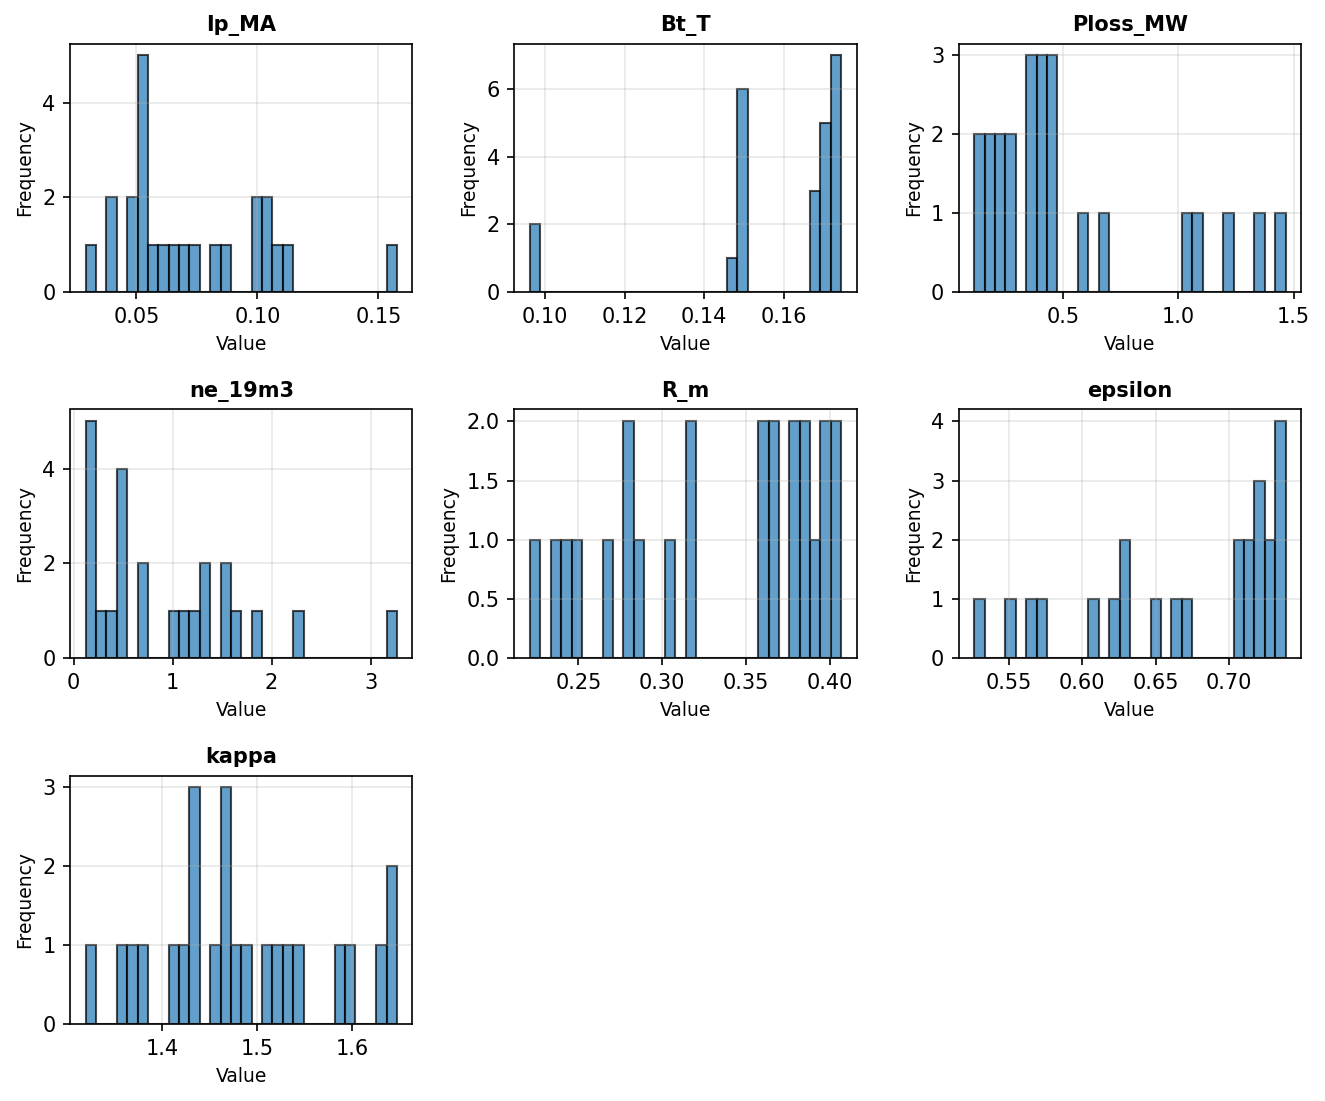

In [29]:
statistical_analysis.confinement_time_histogram(df, eng_params, bins=30)
plt.show()

In [30]:
print("="*60)
print("Performing OLS Regression Analysis")
print("="*60)


print(f"\nEngineering parameters: {eng_params}")
print(f"Target parameter: {target_param}")
print()

results = statistical_analysis.perform_ols_regression(df, eng_params, target_param)

# Display summary
print("\n" + "="*60)
print("Regression Summary")
print("="*60)
print(f"R-squared: {results.rsquared:.4f}")
print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")
print(f"Number of observations: {len(results.fitted_values)}")

print(f"\nCoefficients (Scaling Law Exponents):")
summary = results.get_summary()
print(summary.to_string())

exponents = results.get_exponents()
print(f"\n" + "="*60)
print("Scaling Law Exponents")
print("="*60)
for param, exp in exponents.items():
    print(f"  {param:12s}: {exp:8.4f}")

significance = statistical_analysis.analyze_significance(results, alpha=0.05)
print(f"\n" + "="*60)
print("Statistical Significance (α = 0.05)")
print("="*60)
for param, is_sig in significance.items():
    pval = results.pvalues.get(f'ln_{param}', np.nan)
    status = "✓ Significant" if is_sig else "✗ Not significant"
    print(f"  {param:12s}: {status:20s} (p-value: {pval:.4f})")

Performing OLS Regression Analysis

Engineering parameters: ['Ip_MA', 'Bt_T', 'Ploss_MW', 'ne_19m3', 'R_m', 'epsilon', 'kappa']
Target parameter: tauE_s


Regression Summary
R-squared: 1.0000
Adjusted R-squared: 1.0000
Number of observations: 24

Coefficients (Scaling Law Exponents):
             Coefficient       P-value  Significant
const          -1.932854  5.571493e-18         True
ln_Ip_MA        2.007455  3.907584e-32         True
ln_Bt_T         0.001490  8.866263e-01        False
ln_Ploss_MW    -0.999774  9.903982e-35         True
ln_ne_19m3      0.001518  5.131529e-01        False
ln_R_m          3.716390  1.830909e-21         True
ln_epsilon      1.260929  4.059864e-10         True
ln_kappa       -0.474918  3.411422e-08         True

Scaling Law Exponents
  Ip_MA       :   2.0075
  Bt_T        :   0.0015
  Ploss_MW    :  -0.9998
  ne_19m3     :   0.0015
  R_m         :   3.7164
  epsilon     :   1.2609
  kappa       :  -0.4749

Statistical Significance (α = 0.05)
  Ip_MA     

In [32]:
# Step 4: Compute performance metrics

metrics = statistical_analysis.compute_metrics(results, df, target_param)

print("=== Model Performance Metrics ===")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

=== Model Performance Metrics ===
R2: 0.9999
RMSE: 0.0000
MAE: 0.0000
Mean_Relative_Error_%: 0.3448
Median_Relative_Error_%: 0.2578


Plotting overall fitting results...


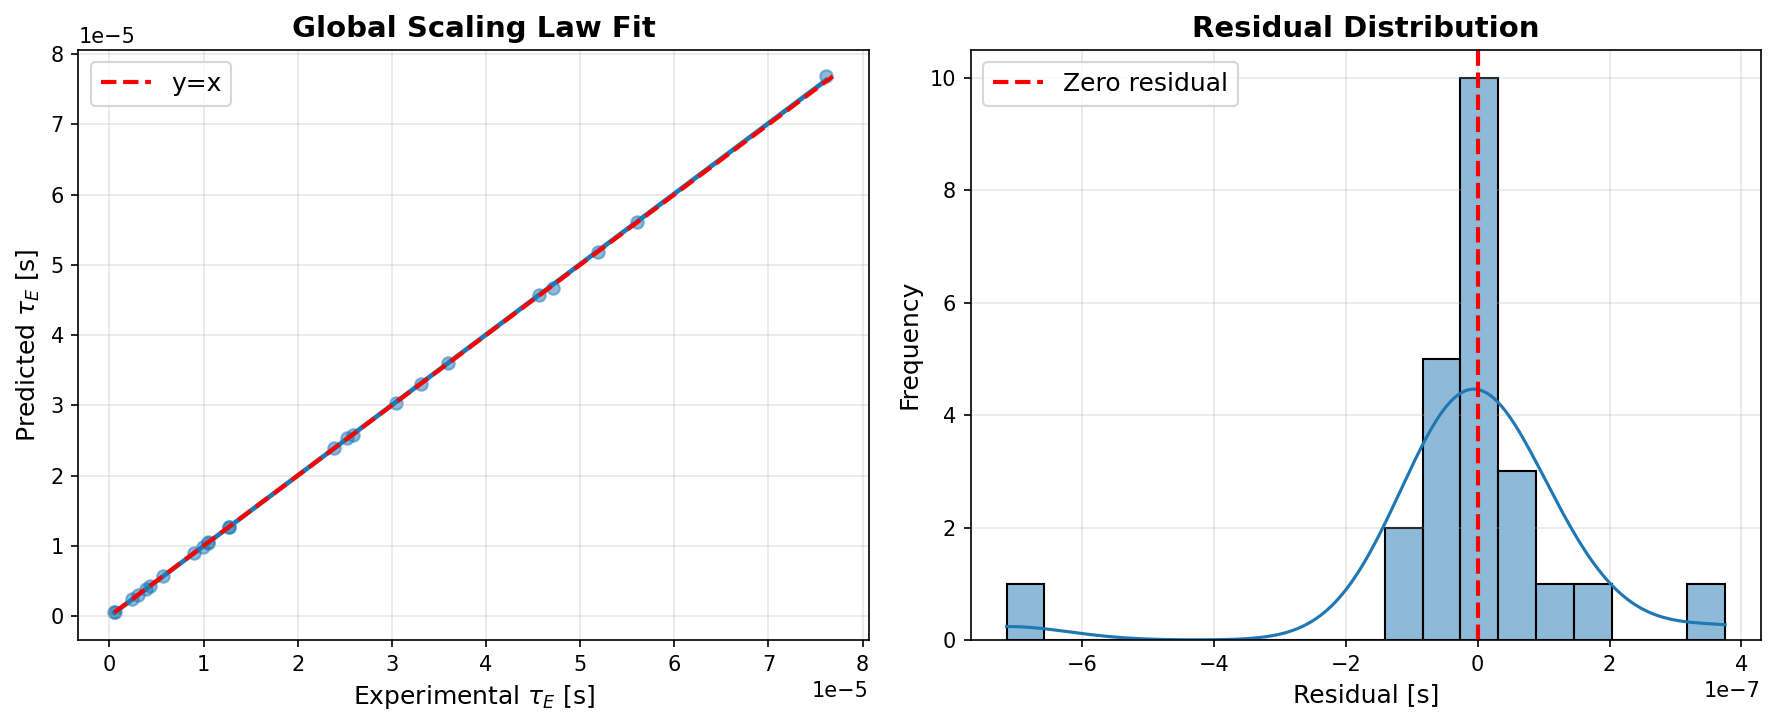

In [33]:
# Step 5: Visualize results

# Plot 1: Overall fitting results and residuals
print("Plotting overall fitting results...")
fig1 = vaft.plot.plot_scaling_fit(results, df, target_param)
plt.show()

Plotting individual parameter effects...


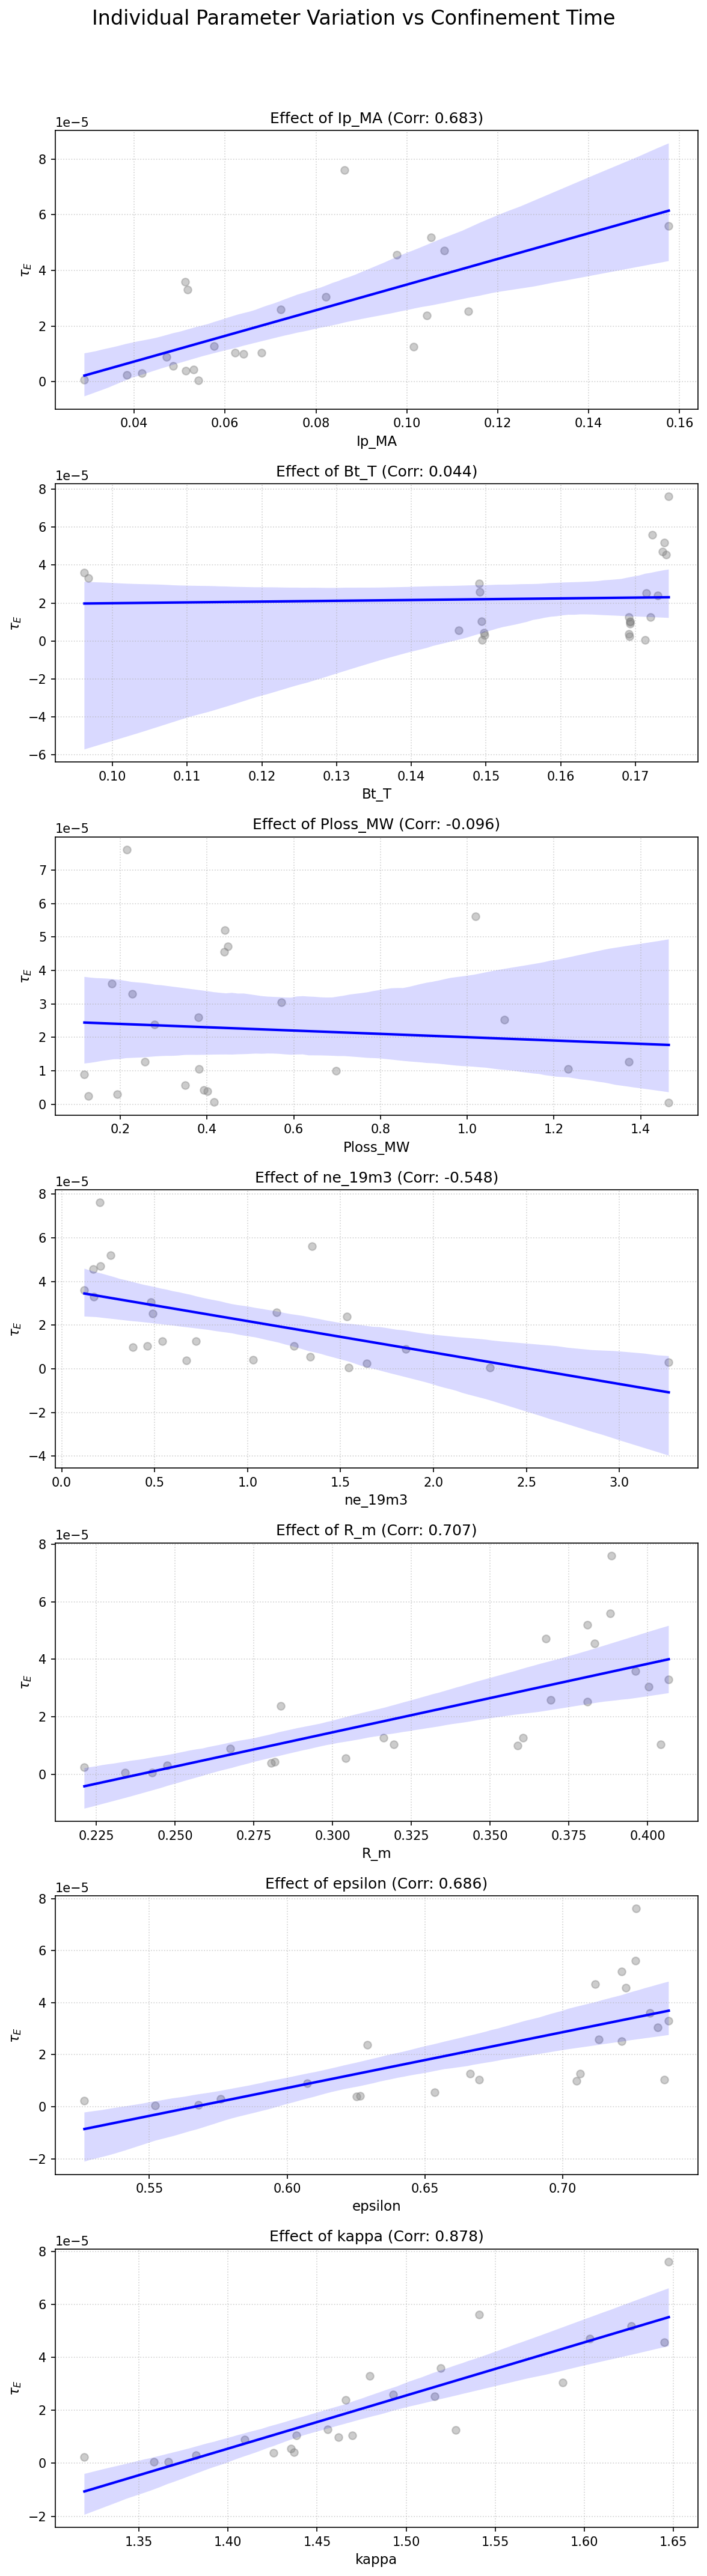

In [34]:
# Plot 2: Individual parameter effects
print("Plotting individual parameter effects...")
fig2 = vaft.plot.plot_individual_parameter_effects(df, eng_params, target_param)
plt.show()

In [ ]:
statistical_analysis.plot_confinement_time_exp_vs_scaling(df, scaling_raw='IPB89', figsize=(10, 6))
statistical_analysis.plot_confinement_time_exp_vs_scaling(df, scaling_raw='H98y2', figsize=(10, 6))
statistical_analysis.plot_confinement_time_exp_vs_scaling(df, scaling_raw='NSTX', figsize=(10, 6))


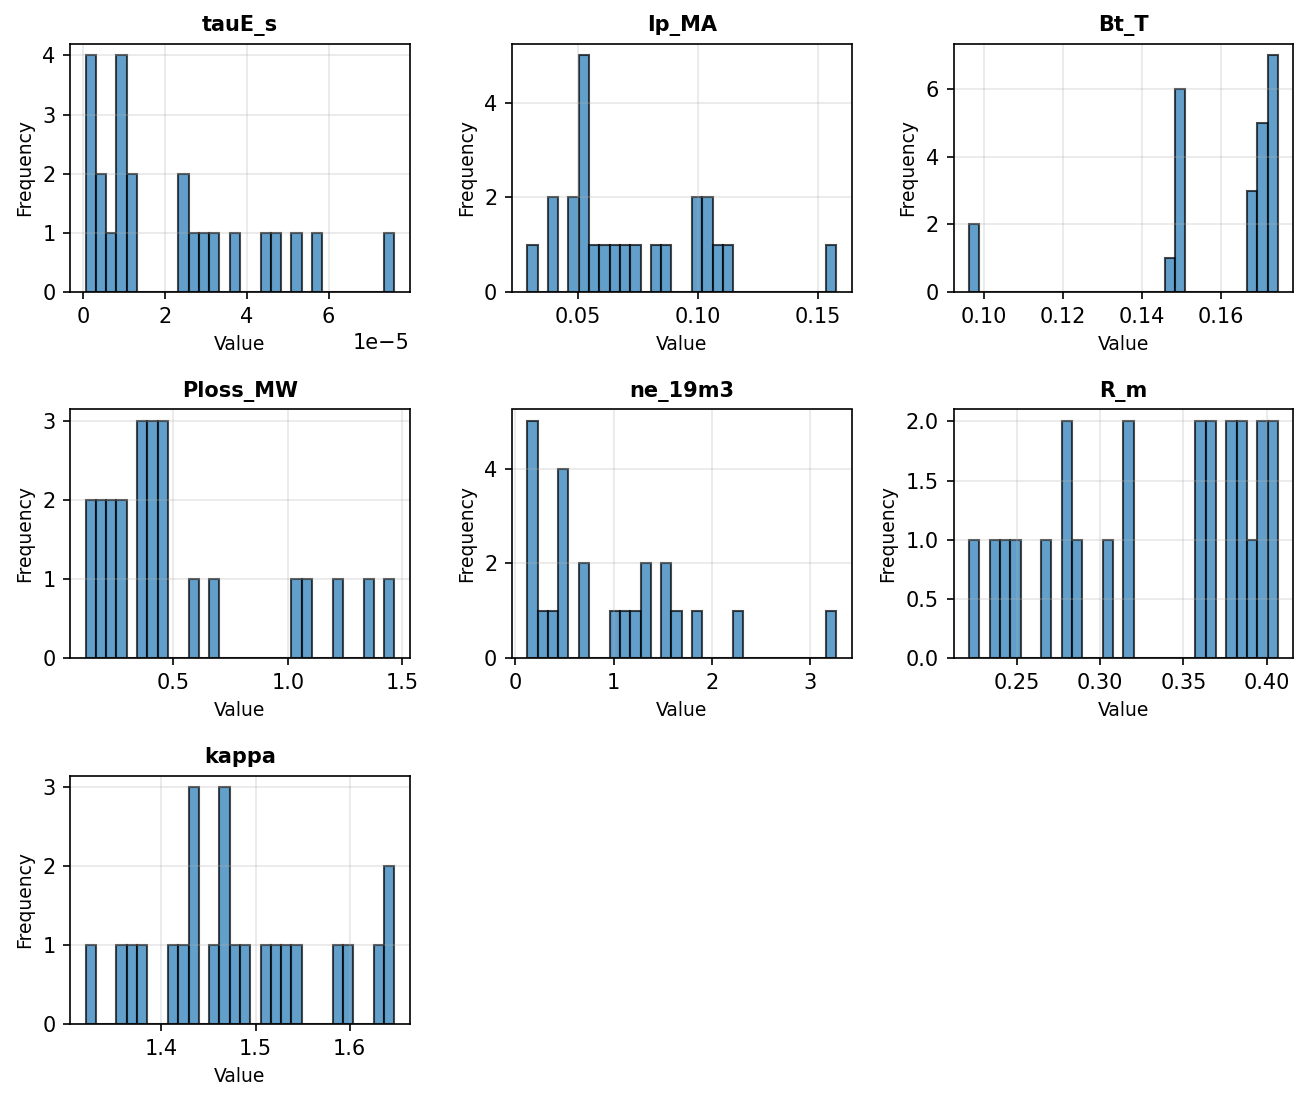

In [26]:
parameters = ['tauE_s', 'Ip_MA', 'Bt_T', 'Ploss_MW', 'ne_19m3', 'R_m', 'a_m', 'kappa']
statistical_analysis.confinement_time_histogram(df, parameters, bins=30)
plt.show()

In [27]:
# Plot 3: Correlation heatmap
print("Plotting correlation heatmap...")
fig3 = vaft.plot.plot_correlation_heatmap(log_df, eng_params, target_param)
if fig3 is not None:
    plt.show()

Plotting correlation heatmap...


NameError: name 'log_df' is not defined

Plotting regression summary...


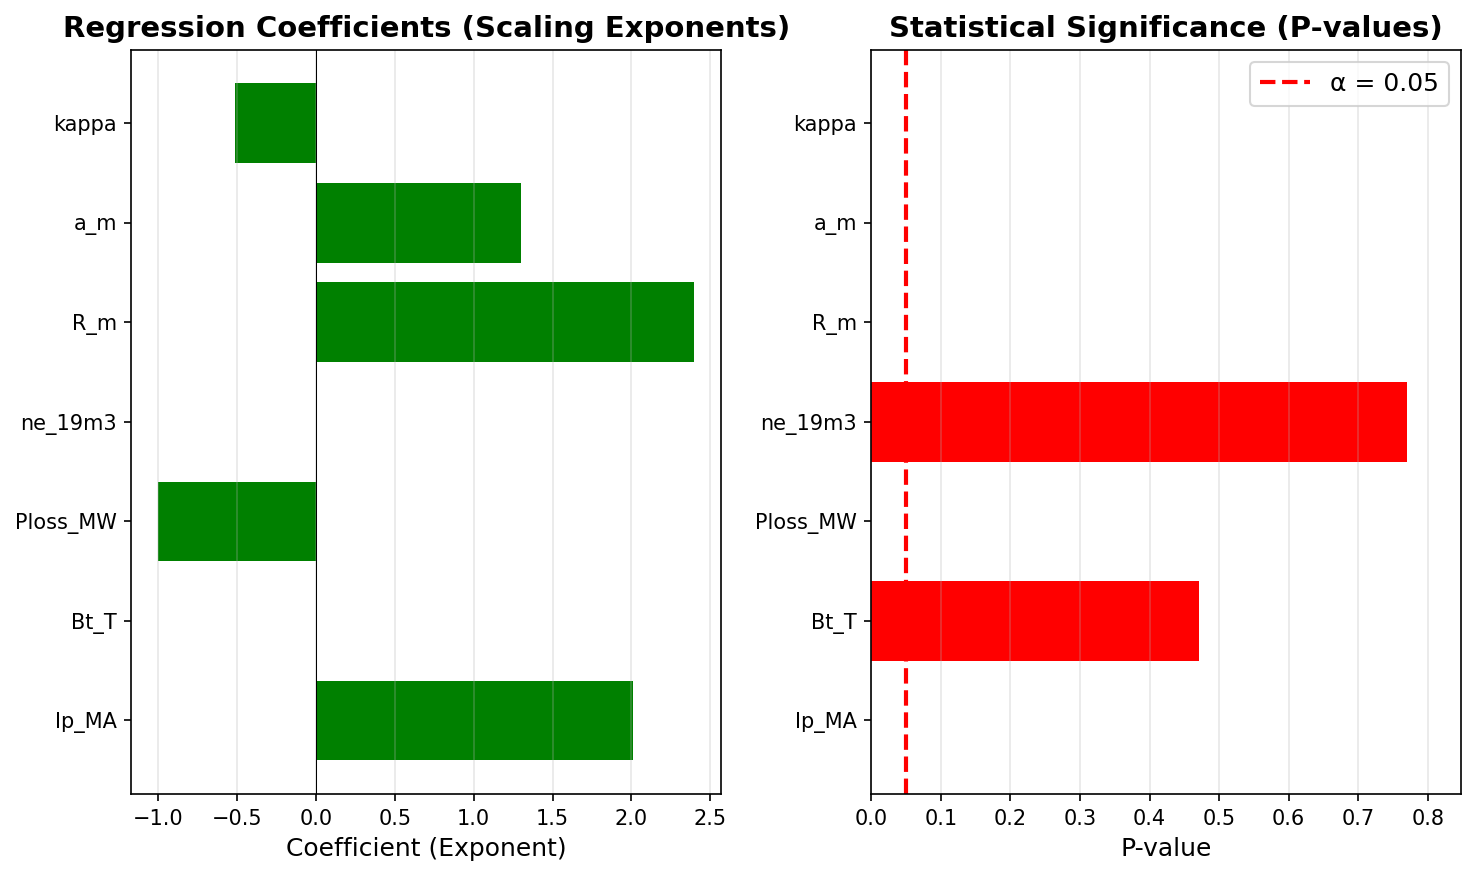

In [ ]:
# Plot 4: Regression summary (coefficients and p-values)
print("Plotting regression summary...")
fig4 = vaft.plot.plot_regression_summary(results)
plt.show()

In [ ]:
# Physical validation and interpretation
print("="*60)
print("Physical Validation and Interpretation")
print("="*60)

print("\nComparing with known scaling laws:")
print("(Reference: IPB98(y,2) scaling law)")

# Expected ranges for IPB98(y,2) (approximate)
expected_ranges = {
    'Ip_MA': (0.9, 1.0),
    'Bt_T': (0.1, 0.2),
    'Ploss_MW': (-0.7, -0.6),
    'ne_19m3': (0.4, 0.5),
    'R_m': (1.3, 1.5),
    'a_m': None,  # Not in standard form
    'kappa': (0.5, 0.7)
}

print("\nExponent Comparison:")
print("-" * 60)
for param in eng_params:
    if param in exponents:
        exp = exponents[param]
        if param in expected_ranges and expected_ranges[param] is not None:
            exp_min, exp_max = expected_ranges[param]
            if exp_min <= exp <= exp_max:
                status = "✓ Within expected range"
            else:
                status = f"✗ Outside expected range ({exp_min:.2f} - {exp_max:.2f})"
            print(f"  {param:12s}: {exp:8.4f}  {status}")
        else:
            print(f"  {param:12s}: {exp:8.4f}  (no reference range)")

print("\n" + "="*60)
print("Model Interpretation")
print("="*60)
print(f"\nModel Performance:")
print(f"  - R² (explained variance): {results.rsquared*100:.1f}%")
print(f"  - Adjusted R²: {results.rsquared_adj*100:.1f}%")
print(f"  - Mean relative error: {metrics.get('Mean_Relative_Error_%', np.nan):.2f}%")

# Significant parameters
sig_params = [p for p, is_sig in significance.items() if is_sig]
non_sig_params = [p for p, is_sig in significance.items() if not is_sig]

print(f"\nStatistically Significant Parameters (p < 0.05):")
if sig_params:
    for param in sig_params:
        pval = results.pvalues.get(f'ln_{param}', np.nan)
        exp = exponents.get(param, np.nan)
        print(f"  ✓ {param:12s}: exponent = {exp:8.4f}, p-value = {pval:.4f}")
else:
    print("  (None)")

if non_sig_params:
    print(f"\nNon-Significant Parameters:")
    for param in non_sig_params:
        pval = results.pvalues.get(f'ln_{param}', np.nan)
        exp = exponents.get(param, np.nan)
        print(f"  ✗ {param:12s}: exponent = {exp:8.4f}, p-value = {pval:.4f}")
    print("\n  Note: These parameters may not have significant impact on")
    print("        confinement time in this dataset, or may be correlated")
    print("        with other parameters (multicollinearity).")

Physical Validation and Interpretation

Comparing with known scaling laws:
(Reference: IPB98(y,2) scaling law)

Exponent Comparison:
------------------------------------------------------------
  Ip_MA       :   2.0122  ✗ Outside expected range (0.90 - 1.00)
  Bt_T        :   0.0025  ✗ Outside expected range (0.10 - 0.20)
  Ploss_MW    :  -0.9998  ✗ Outside expected range (-0.70 - -0.60)
  ne_19m3     :   0.0006  ✗ Outside expected range (0.40 - 0.50)
  R_m         :   2.3982  ✗ Outside expected range (1.30 - 1.50)
  a_m         :   1.2999  (no reference range)
  kappa       :  -0.5148  ✗ Outside expected range (0.50 - 0.70)

Model Interpretation

Model Performance:
  - R² (explained variance): 100.0%
  - Adjusted R²: 100.0%
  - Mean relative error: 0.33%

Statistically Significant Parameters (p < 0.05):
  ✓ Ip_MA       : exponent =   2.0122, p-value = 0.0000
  ✓ Ploss_MW    : exponent =  -0.9998, p-value = 0.0000
  ✓ R_m         : exponent =   2.3982, p-value = 0.0000
  ✓ a_m         

## **Part 3:**
shot #33916